# Switzer method demo
This methodology has not completed WRI's review process and should not be used for any purpose.

Direct questions to Ted Wong (ted.wong@wri.org).

## Problem: How to estimate future probability distributions of climate-hazard indicators
* Data source: climate simulations
    * These are global rasters of CMIP6 simulations. Outputs include daily maxtemp, mintemp, precip, and humidity for every day in years 1950-2100.
    * Downscale product is [NEX-GDDP-CMIP6](https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6). Resolution is 0.25 degrees, or approx. 25 km.
* Additional data: satellite observations
    * This is the [ERA5 reanalysis product](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5), which provides similar variables and resolution for 1940-present.
    * This dataset is not used in the proposed methodology below, but it is available if useful.
    
* Using the simulated variables, for any year we can calculate numerous climate-hazard indicators for any location. Example indicators:
     * Number of days in a year with maxtemp > 35C
     * Duration of longest uninterrupted dryspell in a year
     * Number of degree-days between final frost and first frost in a year
* For a given location and future year, we would like to estimate either...
    * Probability distributions of indicator magnitudes
    * or the probability that the indicator magnitude exceeds a given threshold
* Considerations
    * Ease of calculation
        * Use cases include implementation a a web application for on-demand calculation, and precalculation of large-area rasters. We hope to use methods that lend themselves well to parallelization.
        * We would like to be able to assess the quality of our probability estimates.

## Proposed solution: Random sampling of Poisson rate parameters

* Count exceedance events over a historical interval in both a model and an observation dataset. Also count future exceedance events in one of the climate models.
* Assume counts are Poisson-distributed.
* Using Jeffries prior, the posterior distribution of Poisson rate parameters is Gamma-distributed with shape parameter equal to the event count plus one-half.
* Different models have biases. We'll use the historical observations and historical model data to calibrate each model's future event count. Define a calibration function as follows:
    * Take 10,000 draws from the Gamma distribution using the count from the historical observation dataset as shape parameter. Call these gH_draws.
    * Similar for the historical modeled data: 10,000 draws from Gamma($\alpha$ = historical model count). Call these gHM_draws.
    * Order gH_draws and gHM_draws by size.
    * For j = 1...1000, let X(j,gH) and X(j,gHM) denote the j-th largest value of gH_draws and gHM_draws. Let n(j,gHM) denote the number of gHM sample values that are smaller than X(j,gH). Then the calibrated value of X(j,gHM) is X(n(j),gHM), for j = 1..1000.
    * This defines a mapping from j --> n(j). This mapping is the calibration function.
* Apply the calibration function to gFM_draws to get calibrated gFM_draws, or cgFM_draws. This is the calibrated distribution of Poisson rate parameters.
* Uniformly draw 1000 Poisson parameters from cgFM_draws. Use these 1000 drawn Poisson parameters to generate 1000 Poisson distributions. From each, draw one future exceedance event count.
* Report the mean of the event-count distribution, and display the distribution.
* Do all this for each model and report results separately. Maybe also report the mean value. (Or evaluate models by the distance between gH and gHM, and use only the best model.)




----------------------------------------------------

# Demo implementation

### Import libraries set authentication credentials, etc.

In [1]:
import ee
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import datetime, calendar

plt.style.use("seaborn-darkgrid")

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AVHEtk58KyGx1OnBT4us5pjCirq0w1Ubphv3bpSIe3k6XQ9stgZXROttFkE

Successfully saved authorization token.


--------------------------
### Select CMIP6 models and define a location and future year of interest

--------------------------------------
### Define indicator of interest
Indicator is **one or more consecutive runs (>= 5 days)  between Apr 15 and Sept 10 with min temp > 25C**

In [2]:
indicators = {
    'dtg34': {
            'name': 'dtg34',
            'greaterthan': True,
            'nex_varname': 'tasmax',
            'era5_varname': 'maximum_2m_air_temperature',
            'range': [1, 365, 1],
            'nex_multiply': 1,
            'nex_add': -273.15,
            'era5_multiply': 1,
            'era5_add': -273.15,
            'function': lambda windowdata: np.sum(windowdata >= 35, axis=0),
            'prob_model': 'binomial'
    },
        'mintemp_gt_25_x5': {
            'name': 'mintemp_gt_25_x5',
            'greaterthan': True,
            'nex_varname': 'tasmin',
            'era5_varname': 'minimum_2m_air_temperature',
            'range': [1, 365, 1],
            'nex_multiply': 1,
            'nex_add': -273.15,
            'era5_multiply': 1,
            'era5_add': -273.15,
            'function': lambda windowdata: np.sum(np.diff(np.argwhere(np.logical_not(np.concatenate(([False], windowdata >= 25, [False])))).flatten())[np.argwhere(np.diff(np.argwhere(np.logical_not(np.concatenate(([False], windowdata >= 25, [False])))).flatten()) - 1 > 0).flatten()] - 1 > 5, axis=0),
            'prob_model': 'poisson'
    } 
}

In [3]:
LEAPLENGTH = {'UKESM1-0-LL': 360,
 'NorESM2-MM': 365,
 'NorESM2-LM': 365,
 'MRI-ESM2-0': 366,
 'MPI-ESM1-2-LR': 366,
 'MPI-ESM1-2-HR': 366,
 'MIROC6': 366,
 'MIROC-ES2L': 366,
 'KIOST-ESM': 365,
 'KACE-1-0-G': 360,
 'IPSL-CM6A-LR': 366,
 'INM-CM5-0': 365,
 'INM-CM4-8': 365,
 'HadGEM3-GC31-MM': 360,
 'HadGEM3-GC31-LL': 360,
 'GFDL-ESM4': 365,
 'GFDL-CM4_gr2': 365,
 'GFDL-CM4': 365,
 'FGOALS-g3': 365,
 'EC-Earth3-Veg-LR': 366,
 'EC-Earth3': 366,
 'CanESM5': 365,
 'CNRM-ESM2-1': 366,
 'CNRM-CM6-1': 366,
 'CMCC-ESM2': 365,
 'CMCC-CM2-SR5': 365,
 'BCC-CSM2-MR': 365,
 'ACCESS-ESM1-5': 366,
 'ACCESS-CM2': 366,
 'TaiESM1': 365,
 'ERA5': 366
}

EXCLUDED_MODELS = ['TaiESM1', 'GFDL-CM4_gr2','ERA5']    # TaiESM1 model has major known biases

MODELS = [i for i in LEAPLENGTH.keys() if not i in EXCLUDED_MODELS]

INITIAL_LATLON = (22.75, 87.82)  # near Kolkata
INITIAL_WINDOW = ('04-15', '09-10')

HIST_START = 1979
HIST_END = 2015
FUTURE_START = 2050
FUTURE_END = 2070

NUM_BEST_MODELS = 3

In [4]:
def runlengths(tf_array):
    extended_a = np.concatenate(([False], a, [False]))
    nots = np.argwhere(np.logical_not(extended_a)).flatten()
    diffs = np.diff(nots)
    run_lengths = diffs[np.argwhere(diffs - 1 > 0).flatten()] - 1
    return runlengths
    # Same thing as a lambda function:
    #np.diff(np.argwhere(np.logical_not(np.concatenate(([False], tf_array > 25, [False])))).flatten())[np.argwhere(np.diff(np.argwhere(np.logical_not(np.concatenate(([False], tf_array > 25, [False])))).flatten()) - 1 > 0).flatten()] - 1



def get_mags(lat, lon, window, start_year, end_year, model, indicator, scenario='ssp585'):

# Returns array of event counts, one for each year
    
    print('  {0} {1} - {2}'.format(model, start_year, end_year))
    
    def d2j(datestring):
        d = datetime.date.fromisoformat(datestring)
        jday = d.timetuple().tm_yday
        if calendar.isleap(d.year) and jday > 59:
            jday -= 1
        return jday
    
    if model == 'ERA5':
        varname = indicator['era5_varname']
        is_forecast = varname == "precipitation_amount_1hour_Accumulation"
        dataset = ee.ImageCollection("ECMWF/ERA5/DAILY")
        mult = indicator['era5_multiply']
        add = indicator['era5_add']
    else:
        varname = indicator['nex_varname']
        dataset = ee.ImageCollection('NASA/GDDP-CMIP6').filter(ee.Filter.eq('model', model))
        mult = indicator['nex_multiply']
        add = indicator['nex_add']
    indicator_fxn = indicator['function']
    gee_geom = ee.Geometry.Point((lon, lat))

    allyears = []
    for year in range(start_year, end_year):
        window_start = datetime.datetime.strptime('{0}-{1}'.format(year, window[0]), '%Y-%m-%d')
        window_end_plusone = datetime.datetime.strptime('{0}-{1}'.format(year, window[1]), '%Y-%m-%d') + datetime.timedelta(days=1) 
        data_vars = dataset.select(varname).filter(ee.Filter.date(window_start.strftime('%Y-01-01'), window_end_plusone.strftime('%Y-12-31')))
        if model != 'ERA5':
            data_vars = data_vars.filter(ee.Filter.eq('scenario', [scenario, 'historical'][int(year < 2015)]))
        yeardata = pd.DataFrame(data_vars.getRegion(gee_geom, 25000, 'epsg:4326').getInfo())[4][1:]
        yeardata = np.array(yeardata[d2j(window_start.strftime('%Y-%m-%d'))+1: d2j(window_end_plusone.strftime('%Y-%m-%d'))+1])
        allyears.append(indicator_fxn((np.array(yeardata) * mult) + add))
    return np.array(allyears)

In [5]:
def get_rmsd(d1, d2):
    if d1.size != d2.size:
        raise Exception("Comparing arrays of different length")
    interval_length = d1.size // 4
    c1 = np.array([])
    c2 = np.array([])
    for i in range(4):
        c1 = np.append(c1, sum(d1[i*4:(i+1)*4]))
        c2 = np.append(c2, sum(d2[i*4:(i+1)*4]))
    return np.sqrt(((c1 - c2)**2).sum() / d1.size)

def calibration_function(hist_obs, hist_mod):
    new_indices = []
    source = np.sort(hist_obs)
    target= np.sort(hist_mod)
    source[-1] = target[-1]  # when target[i] greater than all source values, return max index
    for target_idx, target_value in enumerate(target):
        source_value = source[target_idx]
        if target[-1] < source[0]:
            new_indices.append(hist_obs.size - 1)
        else:
            new_indices.append(np.argmax(target >= source_value))
    return new_indices

def get_gamma(count, size):
    return np.random.gamma(shape = count + 0.5, size=size)

def get_beta(count, num, size):
    return np.random.beta(a = count + 0.5, b = num - count + 0.5, size=size)

---------------------------------
### Get historical data and select best models

In [30]:
%%time

indicator = indicators['mintemp_gt_25_x5']
test_threshold = 1

print('Getting historical event counts')
obs_counts = np.array(get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, HIST_START, HIST_END, 'ERA5', indicator))

mod_counts = {}
rmsd_to_models = {}
models_to_rmsd = {}

for model in MODELS:
    mod_counts[model] = np.array(get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, HIST_START, HIST_END, model, indicator))
    rmsd = get_rmsd(obs_counts, mod_counts[model])
    rmsd_to_models[rmsd] = model
    models_to_rmsd[model] = rmsd

rmsd_vals = list(rmsd_to_models.keys())
rmsd_vals.sort()
best_models = [rmsd_to_models[i] for i in rmsd_vals[:NUM_BEST_MODELS]]
print('Best models:')
for model in best_models:
    print('  {0} (RMSD={1})'.format(model, models_to_rmsd[model]))
print('Worst model is {0} (RMSD={1})'.format(rmsd_to_models[rmsd_vals[-1]], rmsd_vals[-1]))

Getting historical event counts
  ERA5 1979 - 2015
  UKESM1-0-LL 1979 - 2015
  NorESM2-MM 1979 - 2015
  NorESM2-LM 1979 - 2015
  MRI-ESM2-0 1979 - 2015
  MPI-ESM1-2-LR 1979 - 2015
  MPI-ESM1-2-HR 1979 - 2015
  MIROC6 1979 - 2015
  MIROC-ES2L 1979 - 2015
  KIOST-ESM 1979 - 2015
  KACE-1-0-G 1979 - 2015
  IPSL-CM6A-LR 1979 - 2015
  INM-CM5-0 1979 - 2015
  INM-CM4-8 1979 - 2015
  HadGEM3-GC31-MM 1979 - 2015
  HadGEM3-GC31-LL 1979 - 2015
  GFDL-ESM4 1979 - 2015
  GFDL-CM4 1979 - 2015
  FGOALS-g3 1979 - 2015
  EC-Earth3-Veg-LR 1979 - 2015
  EC-Earth3 1979 - 2015
  CanESM5 1979 - 2015
  CNRM-ESM2-1 1979 - 2015
  CNRM-CM6-1 1979 - 2015
  CMCC-ESM2 1979 - 2015
  CMCC-CM2-SR5 1979 - 2015
  BCC-CSM2-MR 1979 - 2015
  ACCESS-ESM1-5 1979 - 2015
  ACCESS-CM2 1979 - 2015
Best models:
  ACCESS-ESM1-5 (RMSD=0.7637626158259734)
  HadGEM3-GC31-LL (RMSD=0.7993052538854533)
  UKESM1-0-LL (RMSD=1.118033988749895)
Worst model is CMCC-CM2-SR5 (RMSD=4.272001872658765)
CPU times: total: 9.95 s
Wall time: 3min 4

-------------------------------
### Get samples from posterior distributions and calibrate future samples

Processing ACCESS-ESM1-5
  ACCESS-ESM1-5 2050 - 2070
[1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1]
Processing HadGEM3-GC31-LL
  HadGEM3-GC31-LL 2050 - 2070
[2 1 2 2 1 2 1 2 1 1 1 2 1 2 1 1 1 1 1 1]
Processing UKESM1-0-LL
  UKESM1-0-LL 2050 - 2070
[3 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
CPU times: total: 844 ms
Wall time: 13.4 s


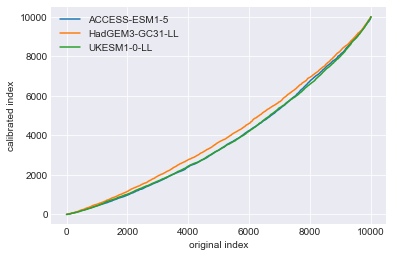

In [31]:
%%time

cposteriorFM_draws = {}
for model in best_models[:3]:
    print('Processing {0}'.format(model))
    fmod = get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, FUTURE_START, FUTURE_END, model, indicator)
    print(fmod)
    if indicator['prob_model'] == 'poisson':
        
        posteriorH_draws = get_gamma(obs_counts.sum(), 10000)
        posteriorHM_draws = get_gamma(mod_counts[model].sum(), 10000)
        posteriorFM_draws = get_gamma(fmod.sum(), 10000)
    else:
        
        fmod = fmod >= test_threshold
        hobs = obs_counts >= test_threshold
        hmod = mod_counts[model] >= test_threshold
        
        posteriorH_draws = get_beta(hobs.sum(), hobs.size, 10000)
        posteriorHM_draws = get_beta(hmod.sum(), hmod.size, 10000)
        posteriorFM_draws = get_beta(fmod.sum(), fmod.size, 10000)
    cf = calibration_function(posteriorH_draws, posteriorHM_draws)
    plt.plot(list(range(10000)), cf, label=model)
    plt.xlabel('original index')
    plt.ylabel('calibrated index')
    plt.legend()
    cposteriorFM_draws[model] = posteriorFM_draws[cf]

In [32]:
cposteriorFM_draws

{'ACCESS-ESM1-5': array([34.02869841, 17.47411217, 17.47411217, ..., 21.03569868,
        39.98746789, 21.71231458]),
 'HadGEM3-GC31-LL': array([29.45670606, 29.45670606, 29.45670606, ..., 34.28806231,
        28.83479808, 22.62798833]),
 'UKESM1-0-LL': array([26.1259318 , 26.1259318 , 26.1259318 , ..., 17.57435348,
        23.24873565, 24.90556314])}

-----------------------------
### Draw binomial (Poisson) rates from the calibrated beta (gamma) draws, and draw from resulting binomial (Poisson) distributions

Visualize the resulting distribution of future event counts

MEAN EVENT COUNT
  1.3 (ACCESS-ESM1-5)
  Probability that event count exceeds 1: 86.26%
  1.4 (HadGEM3-GC31-LL)
  Probability that event count exceeds 1: 90.76%
  1.2 (UKESM1-0-LL)
  Probability that event count exceeds 1: 83.76%


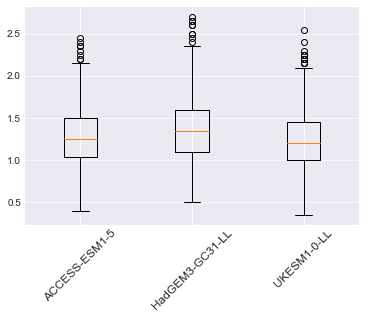

CPU times: total: 188 ms
Wall time: 187 ms


In [12]:
%%time

displaynums = {}
event_distribs = {}
for model in best_models:
    uniform_draws = np.random.randint(low=0, high=10000, size=1000)
    if indicator['prob_model'] == 'poisson':
        cFM_draws = np.random.poisson(lam=cposteriorFM_draws[model][uniform_draws], size=1000) / fmod.size
        displaynums[model] = cFM_draws.mean()
        event_distribs[model] = cFM_draws
    else:
        cFM_draws = np.random.binomial(n=fmod.size, p=cposteriorFM_draws[model][uniform_draws], size=1000) / fmod.size
        displaynums[model] = cFM_draws.mean()
        event_distribs[model] = cFM_draws
if indicator['prob_model'] == 'poisson':
    print('MEAN EVENT COUNT')
    for model in best_models:
        print('  {0:.1f} ({1})'.format(displaynums[model], model))
        d = event_distribs[model]
        d.sort()
        prob_numer = np.trapz(d[np.argmax(d >= test_threshold):])
        prob_denom = np.trapz(event_distribs[model])
        print('  Probability that event count exceeds {0}: {1:.2f}%'.format(test_threshold, prob_numer/prob_denom * 100))
else:
    print('EVENT PROBABILITIES')
    for model in best_models:
        print('  {0:.2f}% ({1})'.format(displaynums[model] * 100, model))
fig, ax = plt.subplots()
ax.boxplot(event_distribs.values())
ax.set_xticklabels(best_models, rotation=45, fontsize=12)
plt.show()

-----------------------------------------
## Same as above, but with an indicator requiring a binomial model

Indicator is **100 or more days between Apr 15 and Sept 10 with max temp >= 35C**

Getting historical event counts
  ERA5 1979 - 2015
  UKESM1-0-LL 1979 - 2015
  NorESM2-MM 1979 - 2015
  NorESM2-LM 1979 - 2015
  MRI-ESM2-0 1979 - 2015
  MPI-ESM1-2-LR 1979 - 2015
  MPI-ESM1-2-HR 1979 - 2015
  MIROC6 1979 - 2015
  MIROC-ES2L 1979 - 2015
  KIOST-ESM 1979 - 2015
  KACE-1-0-G 1979 - 2015
  IPSL-CM6A-LR 1979 - 2015
  INM-CM5-0 1979 - 2015
  INM-CM4-8 1979 - 2015
  HadGEM3-GC31-MM 1979 - 2015
  HadGEM3-GC31-LL 1979 - 2015
  GFDL-ESM4 1979 - 2015
  GFDL-CM4 1979 - 2015
  FGOALS-g3 1979 - 2015
  EC-Earth3-Veg-LR 1979 - 2015
  EC-Earth3 1979 - 2015
  CanESM5 1979 - 2015
  CNRM-ESM2-1 1979 - 2015
  CNRM-CM6-1 1979 - 2015
  CMCC-ESM2 1979 - 2015
  CMCC-CM2-SR5 1979 - 2015
  BCC-CSM2-MR 1979 - 2015
  ACCESS-ESM1-5 1979 - 2015
  ACCESS-CM2 1979 - 2015
{'UKESM1-0-LL': array([59, 44, 95, 53, 62, 56, 73, 91, 58, 67, 48, 57, 52, 41, 44, 69, 56,
       57, 59, 82, 69, 57, 60, 69, 47, 51, 72, 65, 60, 60, 41, 56, 50, 70,
       69, 60]), 'NorESM2-MM': array([50, 55, 48, 50, 58, 55, 55, 5

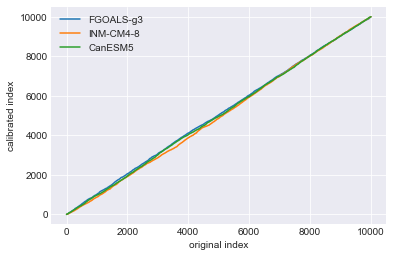

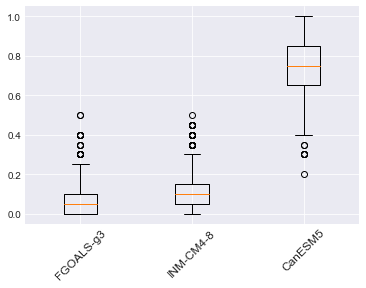

CPU times: total: 15.7 s
Wall time: 15min 57s


In [6]:
%%time

indicator = indicators['dtg34']
test_threshold = 100

print('Getting historical event counts')
obs_counts = np.array(get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, HIST_START, HIST_END, 'ERA5', indicator))

mod_counts = {}
rmsd_to_models = {}
models_to_rmsd = {}

for model in MODELS:
    mod_counts[model] = np.array(get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, HIST_START, HIST_END, model, indicator))
    rmsd = get_rmsd(obs_counts, mod_counts[model])
    rmsd_to_models[rmsd] = model
    models_to_rmsd[model] = rmsd
print(mod_counts)
print(obs_counts)
rmsd_vals = list(rmsd_to_models.keys())
rmsd_vals.sort()
best_models = [rmsd_to_models[i] for i in rmsd_vals[:NUM_BEST_MODELS]]
print('Best models:')
for model in best_models:
    print('  {0} (RMSD={1})'.format(model, models_to_rmsd[model]))
print('Worst model is {0} (RMSD={1})'.format(rmsd_to_models[rmsd_vals[-1]], rmsd_vals[-1]))

cposteriorFM_draws = {}
displaynums = {}
event_distribs = {}

for model in best_models[:3]:
    print('Processing {0}'.format(model))
    fmod = get_mags(INITIAL_LATLON[0], INITIAL_LATLON[1], INITIAL_WINDOW, FUTURE_START, FUTURE_END, model, indicator)
    if indicator['prob_model'] == 'poisson':
        posteriorH_draws = get_gamma(obs_counts.sum(), 10000)
        posteriorHM_draws = get_gamma(mod_counts[model].sum(), 10000)
        posteriorFM_draws = get_gamma(fmod.sum(), 10000)
    else:
        print(model, fmod)
        fmod = fmod >= test_threshold
        hobs = obs_counts >= test_threshold
        hmod = mod_counts[model] >= test_threshold
        
        posteriorH_draws = get_beta(hobs.sum(), hobs.size, 10000)
        posteriorHM_draws = get_beta(hmod.sum(), hmod.size, 10000)
        posteriorFM_draws = get_beta(fmod.sum(), fmod.size, 10000)
    cf = calibration_function(posteriorH_draws, posteriorHM_draws)
    plt.plot(list(range(10000)), cf, label=model)
    plt.xlabel('original index')
    plt.ylabel('calibrated index')
    plt.legend()
    cposteriorFM_draws[model] = posteriorFM_draws[cf]
    
for model in best_models:
    uniform_draws = np.random.randint(low=0, high=10000, size=1000)
    if indicator['prob_model'] == 'poisson':
        cFM_draws = np.random.poisson(lam=cposteriorFM_draws[model][uniform_draws], size=1000) / fmod.size
        displaynums[model] = cFM_draws.mean()
        event_distribs[model] = cFM_draws
    else:
        cFM_draws = np.random.binomial(n=fmod.size, p=cposteriorFM_draws[model][uniform_draws], size=1000) / fmod.size
        displaynums[model] = cFM_draws.mean()
        event_distribs[model] = cFM_draws
if indicator['prob_model'] == 'poisson':
    print('MEAN EVENT COUNT')
    for model in best_models:
        print('  {0:.1f} ({1})'.format(displaynums[model], model))
        d = event_distribs[model]
        d.sort()
        prob_numer = np.trapz(d[np.argmax(d >= test_threshold):])
        prob_denom = np.trapz(event_distribs[model])
        print('  Probability that event count exceeds {0}: {1:.2f}%'.format(test_threshold, prob_numer/prob_denom * 100))
else:
    print('EVENT PROBABILITIES')
    for model in best_models:
        print('  {0:.2f}% ({1})'.format(displaynums[model] * 100, model))
fig, ax = plt.subplots()
ax.boxplot(event_distribs.values())
ax.set_xticklabels(best_models, rotation=45, fontsize=12)
plt.show()